In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential

[1] 데이터 로드 및 분포 확인

In [6]:
raw_df = pd.read_csv('./data/005930.KS.csv')

raw_df['3MA'] = raw_df['Adj Close'].rolling(3).mean()
raw_df['5MA'] = raw_df['Adj Close'].rolling(5).mean()
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4563.383789,74195000,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4167.542969,74680000,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4197.416992,54390000,4309.447917,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4137.667969,40305000,4167.542643,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4309.448730,46880000,4214.844564,4275.09209


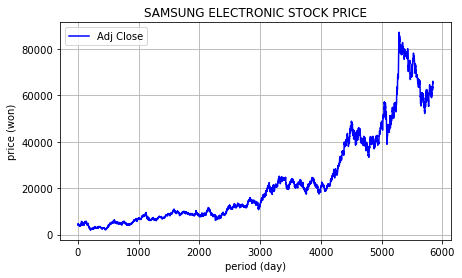

In [8]:
plt.figure(figsize=(7, 4))

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')
plt.legend(loc='best')

plt.show()
# GRU이용하여 20년간의 주가 데이터 학습
# 학습된 모델을 통해 예측

In [9]:
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5.844000e+03,5842.000000,5840.000000
mean,26233.239220,26493.918549,25965.847023,26227.012320,22783.017697,2.142574e+07,22778.858379,22774.653713
std,20860.017097,21028.804605,20681.153275,20843.814212,20377.741257,1.529895e+07,20369.551522,20361.684801
min,2540.000000,2760.000000,2420.000000,2730.000000,2038.958740,0.000000e+00,2083.771037,2098.708496
25%,10375.000000,10520.000000,10260.000000,10400.000000,7872.025391,1.172968e+07,7877.003703,7889.395947
50%,17870.000000,18020.000000,17670.000000,17870.000000,14120.687500,1.737548e+07,14119.659180,14144.406934
75%,41112.500000,41542.500000,40850.000000,41210.000000,35405.623047,2.659555e+07,35464.105143,35411.350391
max,90300.000000,96800.000000,89500.000000,91000.000000,87219.484375,1.642150e+08,86676.354167,86222.682813


In [10]:
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          2
5MA          4
dtype: int64

In [12]:
# Volume값 0을 모두 NaN으로 대체

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column의 0 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col] == 0].shape[0]
    print(col + ' : ' + str(missing_rows))

Date : 0
Open : 0
High : 0
Low : 0
Close : 0
Adj Close : 0
Volume : 0
3MA : 0
5MA : 0


In [13]:
raw_df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       127
3MA            2
5MA            4
dtype: int64

In [14]:
raw_df = raw_df.dropna()

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [15]:
# 딥러닝 학습이 잘되기 위해서는 정규화 작업이 필요
# 즉 날짜를 나타내는 Date항목을 제외한 숫자로 표현되는 모든 column에 대해서 0~1값으로 정규화 수행

# 데이터 전처리 - 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', '3MA', '5MA', 'Volume'] # 정규화 대상 column 정의

scaled_df = scaler.fit_transform(raw_df[scale_cols]) # 정규화 수행

print(type(scaled_df), '\n') # fin_transform의 return값이 numpy

scaled_df = pd.DataFrame(scaled_df, columns = scale_cols) # 정규화된 새로운 DataFrame생성

print(scaled_df)

<class 'numpy.ndarray'> 

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5708  0.709435  0.675670  0.715204  0.713379   0.747366  0.735875  0.736976   
5709  0.725387  0.674607  0.723243  0.715645   0.749714  0.750061  0.742445   
5710  0.720830  0.674607  0.722095  0.716778   0.750888  0.754001  0.747439   
5711  0.718551  0.673543  0.723243  0.717911   0.752062  0.755577  0.756475   
5712  0.729945  0.678860  0.718650  0.706582   0.740322  0.752425  0.756712   

        Volume  
0     0.

In [16]:
# feature columns / label column 정의

# 딥러닝 학습을 위한 입력데이터 feature column, 정답 데이터 label column 정의 후  numpy로 변환하여 데이터 전처리 과정 완료

feature_cols = ['3MA', '5MA', 'Adj Close'] # feature 정의(입력 데이터)
label_cols = ['Adj Close']                         # label 정의(정답 데이터)

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

print(feature_df)
print(label_df)

label_np = label_df.to_numpy() # 딥러닝 학습을 위해 DataFrame -> numpy 변환
feature_np = feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.025192  0.025698   0.026655
1     0.025634  0.025094   0.026655
2     0.026163  0.025343   0.026217
3     0.025987  0.025503   0.026129
4     0.026163  0.026018   0.027181
...        ...       ...        ...
5708  0.735875  0.736976   0.747366
5709  0.750061  0.742445   0.749714
5710  0.754001  0.747439   0.750888
5711  0.755577  0.756475   0.752062
5712  0.752425  0.756712   0.740322

[5713 rows x 3 columns]
      Adj Close
0      0.026655
1      0.026655
2      0.026217
3      0.026129
4      0.027181
...         ...
5708   0.747366
5709   0.749714
5710   0.750888
5711   0.752062
5712   0.740322

[5713 rows x 1 columns]


데이터 생성

In [17]:
# 입력 파라미터 feature, label => numpy type

def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] # 생성될 feature_list
    label_list = []     # 생성될 label_list
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)
    # feature_list = [[..], [..], [..], ..] 이므로 리턴 값 np.array(feature_list)는 (batch_size, time_steps, input_dims) 형상을 가짐

In [18]:
# 학습데이터 X, Y 생성

window_size = 40

X, Y  = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5673, 40, 3) (5673, 1)


In [19]:
# 트레이닝 데이터 / 테스트 데이터 분리
split = -200

x_train = X[0 : split]
y_train = Y[0 : split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
# train data 5473, test 200

(5473, 40, 3) (5473, 1)
(200, 40, 3) (200, 1)


In [22]:
# GRU 모델 구축

model = Sequential()

model.add(GRU(256,
                             activation='tanh', # LSTM계층에 tanh를 활성화 함수로 가지는 노드 수 256개 
                             input_shape=x_train[0].shape)) # input_shape = (40, 3) 40개의 데이터로 미래 값 예측

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               200448    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 모델 컴파일 및 학습

from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
343/343 [==============================] - 32s 76ms/step - loss: 7.8681e-04 - mae: 0.0102 - val_loss: 3.7752e-04 - val_mae: 0.0166
Epoch 2/100
343/343 [==============================] - 24s 71ms/step - loss: 8.3782e-05 - mae: 0.0059 - val_loss: 2.4243e-04 - val_mae: 0.0122
Epoch 3/100
343/343 [==============================] - 24s 71ms/step - loss: 7.4337e-05 - mae: 0.0055 - val_loss: 1.4461e-04 - val_mae: 0.0096
Epoch 4/100
343/343 [==============================] - 24s 70ms/step - loss: 6.7309e-05 - mae: 0.0054 - val_loss: 1.6288e-04 - val_mae: 0.0100
Epoch 5/100
343/343 [==============================] - 24s 71ms/step - loss: 7.8280e-05 - mae: 0.0058 - val_loss: 1.2912e-04 - val_mae: 0.0092
Epoch 6/100
343/343 [==============================] - 24s 70ms/step - loss: 6.1197e-05 - mae: 0.0052 - val_loss: 1.4762e-04 - val_mae: 0.0095
Epoch 7/100
343/343 [==============================] - 24s 71ms/step - loss: 4.9695e-05 - mae: 0.0046 - val_loss: 1.5326e-04 - val_mae: 0.0103

7/7 [==============================] - 1s 40ms/step


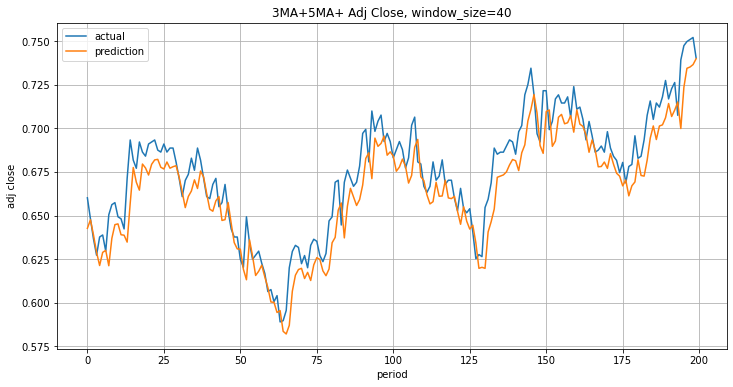

In [24]:
# 삼성전자 주가 예측

pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA+5MA+ Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()